# Reduce Science images : Example of HD158485
=========================================================================


- Creation : Friday 2016 June 10th
- Update : Monday 2016 June 13th
- Author Sylvie Dagoret-Campagne (SDC adapted for LSST from Matt Craig's example notebook)
- affiliation : LAL/IN2P3/CNRS


Do the ISR for sciencie images. In this ipython notebook work with HD158485



## 1) Import used packages
===================================

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
from scipy import stats  
import os
from datetime import datetime, timedelta

In [3]:
import libMonocamBaseImages

In [4]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-20 19:07:02.233200
fits date format for the analysis :  2016-06-20T19:07:02


## 2) Detector configuration
====================================

In [5]:
NB_OF_CHAN_AMPL=16    # 16 images in each of the fits file

## 3) Get the master bias 
===============================

In [6]:
path='.'
basefilename='masterbias_ostrim_1.fits' # check master bias
filename=os.path.join(path,basefilename)
vmin=-2
vmax=2
outputfigfilename='MasterBiasUsedinISR_img.pdf'

In [7]:
allbias = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    allbias.append(ccd_chan)

In [8]:
mbheader=allbias[0].header
mbheader['DATE-ANA']=date_of_analysis

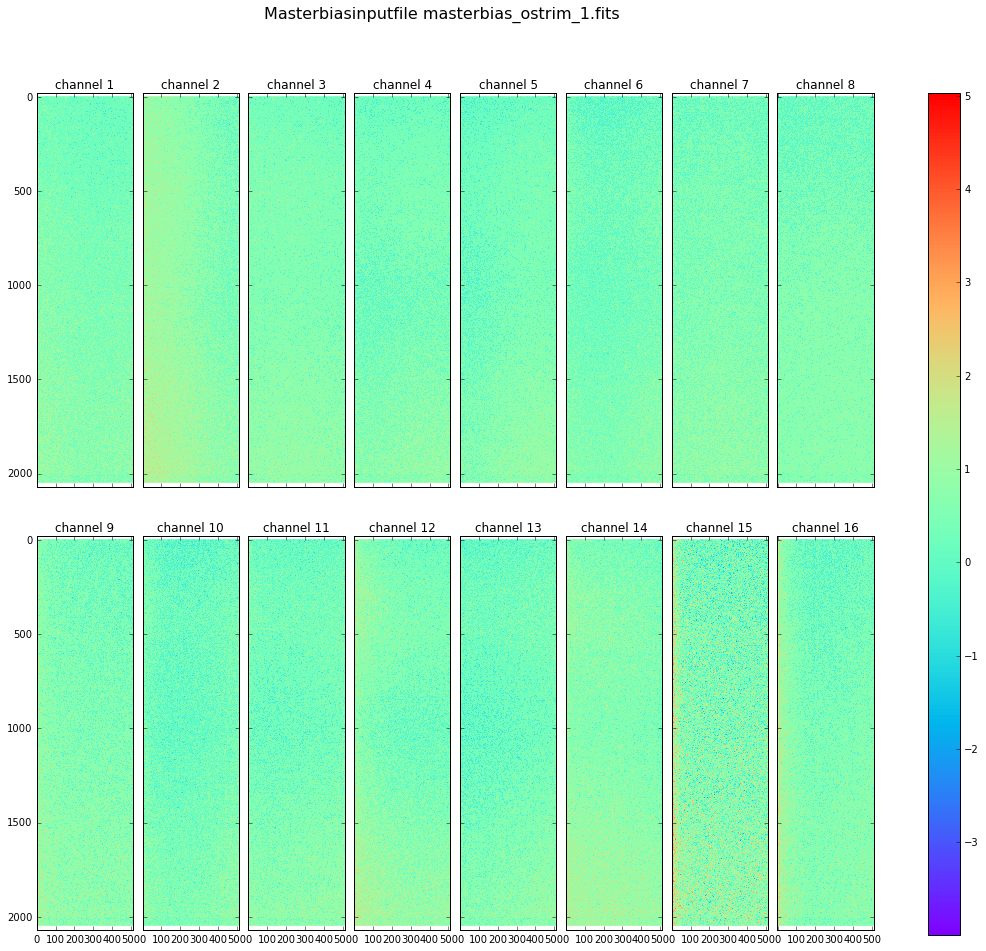

In [9]:
libMonocamBaseImages.ShowImagesSet(allbias,'Masterbias',basefilename,outputfigfilename,nbsig=10)

In [10]:
#libMonocamBaseImages.ShowHistoSet(allbias,'Masterbias distributions',basefilename,'masterbiases_hist.pdf',nbsig=10)

## 4) Get the scaled darks
=================================

In [11]:
path='.'
basefilename='masterdarkscaled_ostrim_1.fits' # check master dark
filename=os.path.join(path,basefilename)
outputfigfilename='MasterDarkUsedinISR_img.pdf'

In [12]:
alldarks = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    alldarks.append(ccd_chan)

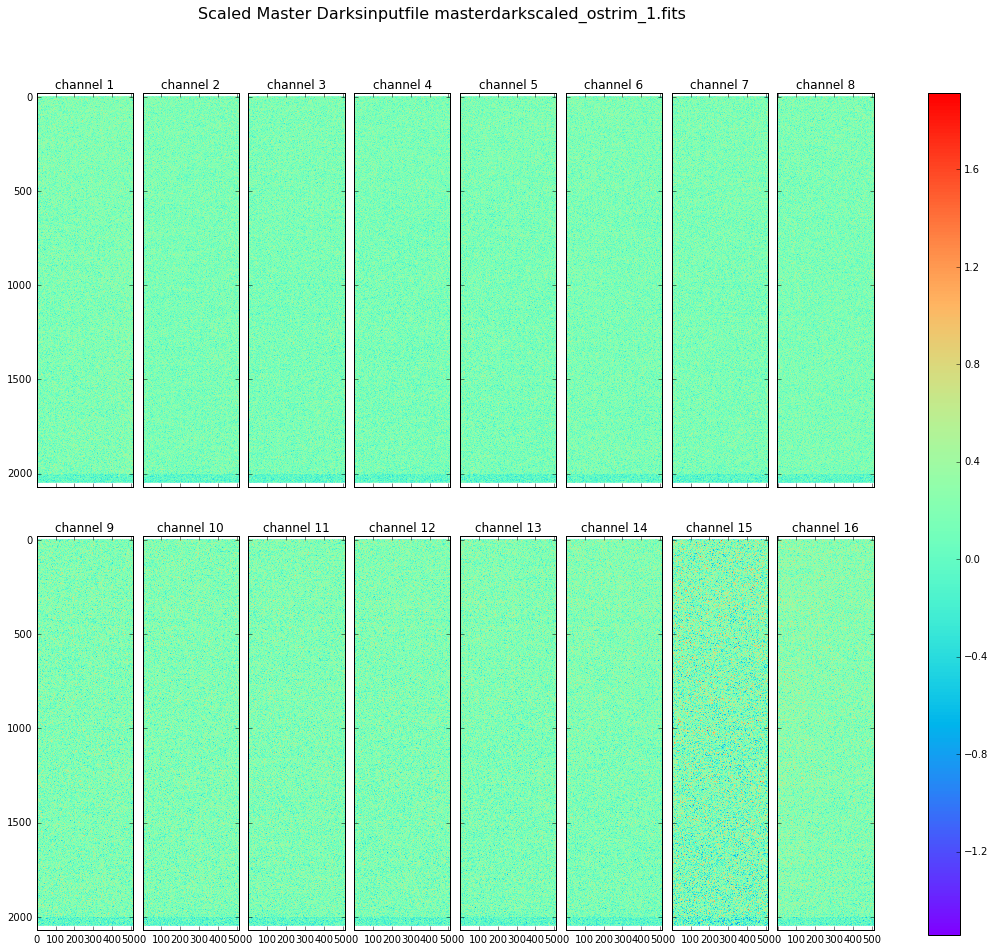

In [13]:
libMonocamBaseImages.ShowImagesSet(alldarks,'Scaled Master Darks',basefilename,outputfigfilename,nbsig=10)

In [14]:
#libMonocamBaseImages.ShowHistoSet(alldarks,'Masterdarks distributions',basefilename,'masterdarks_hist.pdf',nbsig=10)

## 5)  Get the Master flats
================================

In [15]:
path='.'
basefilename='masterflat_1-40.fits' # check master bias
filename=os.path.join(path,basefilename)
vmin=-2
vmax=2
outputfigfilename='MasterFlatUsedinISR_img.pdf'

In [16]:
allflats = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    allflats.append(ccd_chan)

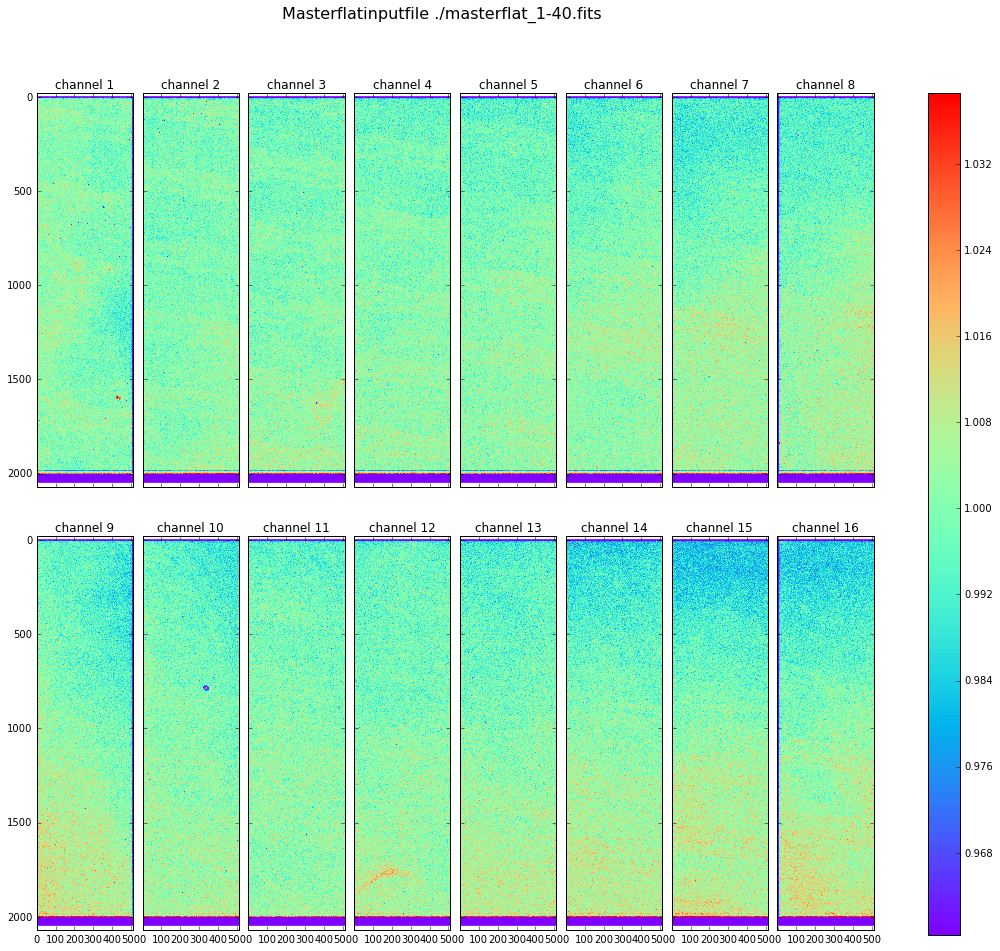

In [17]:
libMonocamBaseImages.ShowImagesSet(allflats,'Masterflat',filename,outputfigfilename,nbsig=3)


## 6) Analyse the science image
========================================

### 6.1) Define overscan

In [18]:
def oscan_and_trim(image_list):
    """
    Remove overscan and trim a list of images. The original list is replaced by a list of images
    with the changes applied.
    """
    for idx, img in enumerate(image_list):
        oscan = ccdproc.subtract_overscan(img,overscan=img[:,521:544], add_keyword={'oscan_sub': True, 'calstat': 'O'}, model=models.Polynomial1D(1))
        image_list[idx] = ccdproc.trim_image(oscan[:,10:521], add_keyword={'trimmed': True, 'calstat': 'OT'})

### 6.2)  Define the filenames

In [19]:
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
root_sciimagefilename='HD158485_grat_'
sciimage_startnum=1
sciimage_stopnum=25
outputfigfilename=root_sciimagefilename+'img'+'.pdf'
outputfigfilename2=root_sciimagefilename+'hist'+'.pdf'
outputfitsfilename=root_sciimagefilename+'science'+'.fits'
root_sciimagefilename0='HD158485_grat'
image_type='science HD158485_grat'

### 6.3) Build the filelist

In [20]:
rawsciimages_list=libMonocamBaseImages.BuildFilelist(path,root_sciimagefilename,start=sciimage_startnum,stop=sciimage_stopnum)

In [21]:
NB_OF_SCIIMAGES=len(rawsciimages_list)

### 6.4) Read the science images

In [22]:
allchannelallsciimages = []  # list of 16 lists of images series 
exposures_list = []        # sequential list of the exposures of the sky flats 
header_list = []           # list of headers

# get the primary block headers:
for image_file in rawsciimages_list: 
    hdu_list = fits.open(image_file)
    header=hdu_list[0].header
    number_of_channels=header['CHAN']
    exposure=header['EXPOSURE']
    exposures_list.append(exposure)
    header_list.append(header)

# get the CCD images:
for chan in range(1,NB_OF_CHAN_AMPL+1,1): # loop on channel
    fileindex=0
    allsciimages = []  # container of flats for a given channel
    for image_file in rawsciimages_list:       
        ccd_chan = ccdproc.CCDData.read(image_file, hdu=chan,unit="adu")
        allsciimages.append(ccd_chan)  # image extension
        fileindex=fileindex+1
    allchannelallsciimages.append(allsciimages)

In [23]:
#exposures_list

In [24]:
mbheader=allchannelallsciimages[0][0].header
mbheader['DATE-ANA']=date_of_analysis

### 6.5)  Shows one uncalibrated Science image

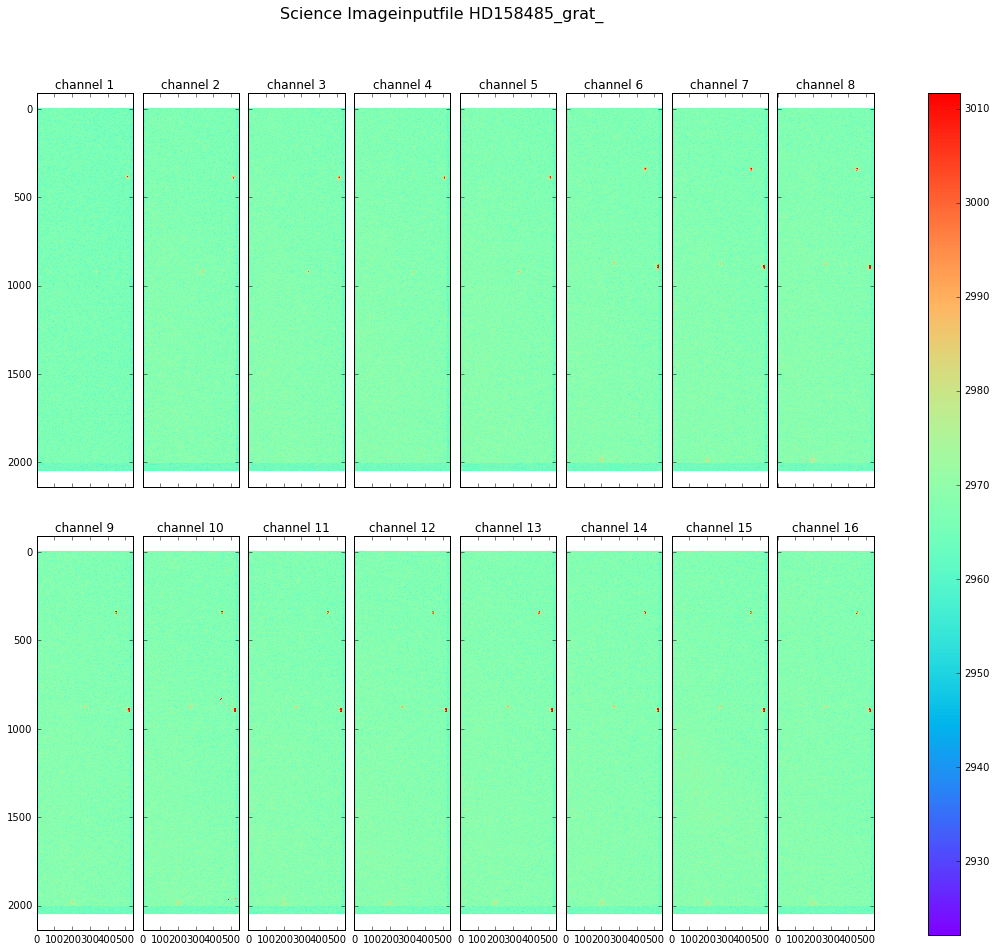

In [25]:
libMonocamBaseImages.ShowImagesSet(allchannelallsciimages[0],'Science Image',root_sciimagefilename,outputfigfilename,nbsig=3.)

In [26]:
#index=0

### 6.7) Calibrate all science images  

In [27]:
allchannelscorrectedimages = [] 
for im in range(NB_OF_SCIIMAGES): # loop over fits file images
    ccd_subset_of_16corrimages=[] # collector of corrected 16 sub-images per image fits-file
    for chan in range(NB_OF_CHAN_AMPL): # loop on channels
        correctedimage=ccdproc.ccd_process(allchannelallsciimages[chan][im], # apply all corrections
                                           oscan='[522:544,:]',              # substract osverscan region
                                           trim='[11:521,:]',                # does the trimming
                                           error=False,      
                                           master_bias=allbias[chan],        # bias subtraction
                                           dark_frame=alldarks[chan],        # normalised dark  
                                           dark_exposure=1*u.second,         # duration of the dark exposure
                                           data_exposure=exposures_list[im]*u.second, # duration of data exposure
                                           dark_scale=True,                  # normalize the dark to data exposure
                                           master_flat=allflats[chan],       # master flat
                                           add_keyword={'oscan_sub': True,'calstat': 'OTBDF'}
                                          )
        ccd_subset_of_16corrimages.append(correctedimage)
    allchannelscorrectedimages.append(ccd_subset_of_16corrimages)

### 6.8) Shows all calibrated images

consume much memory : uncomment for debugging if necessary

In [28]:
#for im in range(NB_OF_SCIIMAGES): # loop over fits file images
#    image_title='Science Image '+str(im)+' :: '
#    root_sciimagefilename=os.path.basename(rawsciimages_list[im])
#    outputfigfilename=root_sciimagefilename.split('.')[0]+'.pdf'    
    #print image_title,root_sciimagefilename , outputfigfilename
#    libMonocamBaseImages.ShowImagesSet(allchannelscorrectedimages[im],image_title,root_sciimagefilename,outputfigfilename,nbsig=1.)

## 7) Combine the Science Images

### 7.1) reordering

In [29]:
allchannelsstackedimages = [] 
for chan in range(NB_OF_CHAN_AMPL): # loop on channels
    stackedimages_per_ampl = []
    for im in range(NB_OF_SCIIMAGES): # loop over fits file images
        cdd_image=allchannelscorrectedimages[im][chan]
        stackedimages_per_ampl.append(cdd_image)
    allchannelsstackedimages.append(stackedimages_per_ampl)       

### 7.2) stacking

In [30]:
all_stacked_science_images= []
for chan in range(NB_OF_CHAN_AMPL):
    all_stacked_science_images.append(ccdproc.Combiner(allchannelsstackedimages[chan]).average_combine())

### 7.3) Show the combined image

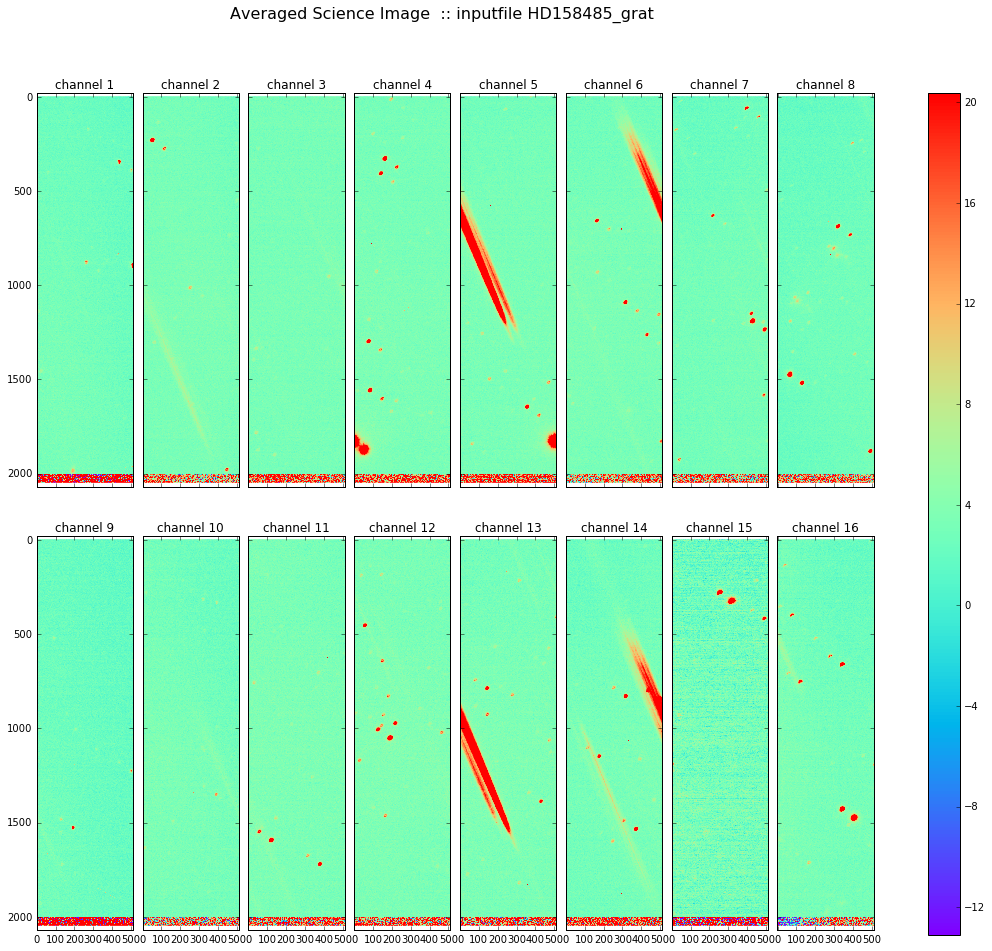

In [31]:

image_title='Averaged Science Image  :: '
root_sciimagefilename=root_sciimagefilename0
outputfigfilename=root_sciimagefilename.split('.')[0]+'.pdf'      
libMonocamBaseImages.ShowImagesSet(all_stacked_science_images,image_title,root_sciimagefilename,outputfigfilename,nbsig=1.)

### 7.5) Save in a fits file

In [32]:
libMonocamBaseImages.SaveCCDListIntoFitsFile(all_stacked_science_images,outputfitsfilename,mbheader,imagetyp=image_type)

Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                ImageHDU         7   (511, 2048)   float64   
2                ImageHDU         7   (511, 2048)   float64   
3                ImageHDU         7   (511, 2048)   float64   
4                ImageHDU         7   (511, 2048)   float64   
5                ImageHDU         7   (511, 2048)   float64   
6                ImageHDU         7   (511, 2048)   float64   
7                ImageHDU         7   (511, 2048)   float64   
8                ImageHDU         7   (511, 2048)   float64   
9                ImageHDU         7   (511, 2048)   float64   
10               ImageHDU         7   (511, 2048)   float64   
11               ImageHDU         7   (511, 2048)   float64   
12               ImageHDU         7   (511, 2048)   float64   
13               ImageHDU         7   (511, 2048)   float64   
14               Im

### 7.6) Show Histograms

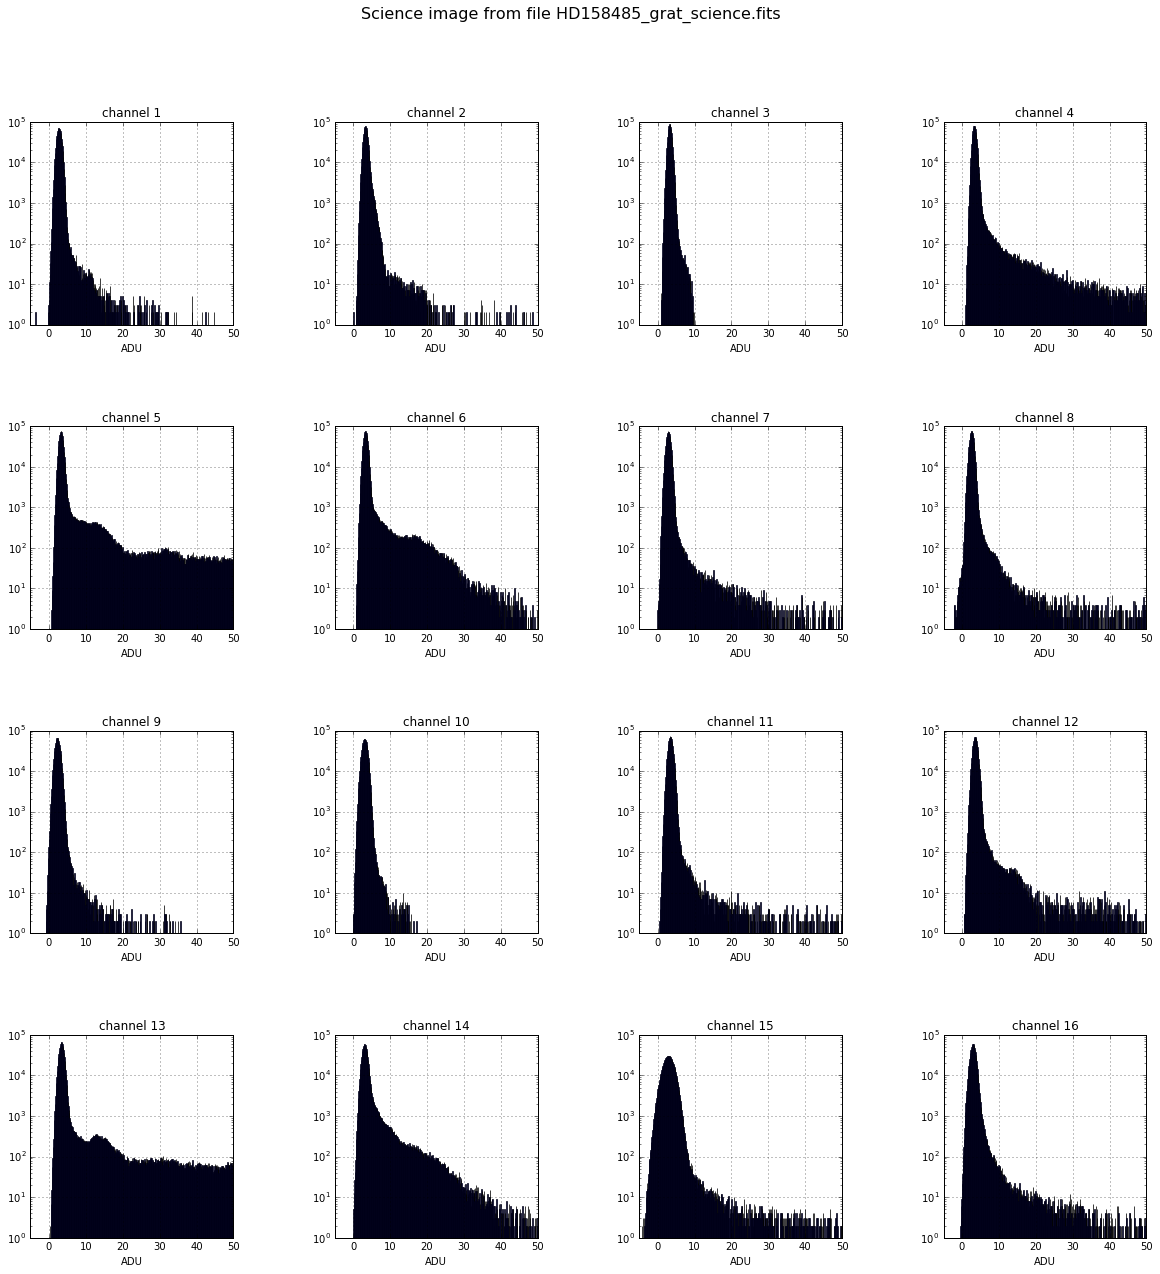

In [33]:
libMonocamBaseImages.ShowHistoSetFixedBound(all_stacked_science_images,'Science image',outputfitsfilename,outputfigfilename2,Vmin=-5,Vmax=50.)